1. **Checking** GPU integration.


In [1]:
!nvidia-smi



Mon Jan 12 14:54:26 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

2. Mounting FALCON DATASET


In [4]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd /content/drive/MyDrive
!ls


/content/drive/MyDrive
'20230824_143247 (1).jpg'
'20230824_143247 (2).jpg'
'20230824_143247 (3).jpg'
 20230824_143247.jpg
'2025 Year Recap'
 Aadhaar_SarbajitKumarDe.gdoc
 Aadhaar_SarbajitKumarDe.pdf
'Author information.gsheet'
'Blood Relations Assignment.pdf'
'Central PPT_BTHIVCBSH181_Module_1_Notes.gslides'
'Central PPT_IVC102_Module_2_Notes.gslides'
'Central PPT_IVC102_Module_3_Notes.gslides'
'Chemistry Project.pdf'
 Classroom
'Colab Notebooks'
'Customer Feedback.gform'
'Customer Feedback (Responses).gsheet'
'CV OFFICIAL.pdf-1.pdf'
 DesignThinkingProject.pdf
'Direction Test Assignment-1 ESP-1.pdf'
 Doc
'Electrical Project.pdf'
'Elephant Toothpaste Experiment.docx'
'Empathy map.pdf'
'English Research paper.gdoc'
'English Research paper.pdf'
'Frame 1000006222.png'
'Milestone 1 ArtistryConnect.pptx'
'Model Making..docx'
'Neutral Collage Recap Instagram Post (1)'
 Offroad_Segmentation_Training_Dataset
'python project.docx'
 Resume.pdf
'RSVP (1).gform'
 RSVP.gform
 SarbajitKumarDe_2403109

In [6]:
%cd Offroad_Segmentation_Training_Dataset
!ls


/content/drive/MyDrive/Offroad_Segmentation_Training_Dataset
Offroad_Segmentation_Training_Dataset


In [7]:
%cd Offroad_Segmentation_Training_Dataset
!ls

/content/drive/MyDrive/Offroad_Segmentation_Training_Dataset/Offroad_Segmentation_Training_Dataset
train  val


In [8]:
!ls train


images	masks


In [9]:
# Go to the dataset root (you are already here, but ensure)
%cd /content/drive/MyDrive/Offroad_Segmentation_Training_Dataset/Offroad_Segmentation_Training_Dataset


/content/drive/MyDrive/Offroad_Segmentation_Training_Dataset/Offroad_Segmentation_Training_Dataset


In [10]:
!mv train/Color_Images train/images
!mv train/Segmentation train/masks


mv: cannot stat 'train/Color_Images': No such file or directory
mv: cannot stat 'train/Segmentation': No such file or directory


In [11]:
!mv val/Color_Images val/images
!mv val/Segmentation val/masks


mv: cannot stat 'val/Color_Images': No such file or directory
mv: cannot stat 'val/Segmentation': No such file or directory


In [12]:
!ls train
!ls val


images	masks
images	masks


In [13]:
!ls train/images | head
!ls train/masks | head


cc0000012.png
cc0000013.png
cc0000014.png
cc0000015.png
cc0000017.png
cc0000018.png
cc0000021.png
cc0000022.png
cc0000023.png
cc0000025.png
cc0000012.png
cc0000013.png
cc0000014.png
cc0000015.png
cc0000017.png
cc0000018.png
cc0000021.png
cc0000022.png
cc0000023.png
cc0000025.png


In [14]:
!pwd


/content/drive/MyDrive/Offroad_Segmentation_Training_Dataset/Offroad_Segmentation_Training_Dataset


3.Installing Dependencies


In [15]:
!ls

train  val


In [17]:
!pip install -U segmentation-models

import tensorflow as tf
import os
import numpy as np

# Set framework to tensorflow for segmentation-models
os.environ['SM_FRAMEWORK'] = 'tf.keras'

import segmentation_models as sm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 7.7 MB/s eta 0:00:00
Segmentation Models: using `tf.keras` framework.


LABELING


In [19]:
BACKBONE = 'resnet50'
CLASSES = 10
IMG_SIZE = 256

preprocess_input = sm.get_preprocessing(BACKBONE)


In [20]:
# Official dataset label IDs → class indices (0–9)
LABEL_MAP = {
    100: 0,    # Trees
    200: 1,    # Lush Bushes
    300: 2,    # Dry Grass
    500: 3,    # Dry Bushes
    550: 4,    # Ground Clutter
    600: 5,    # Flowers
    700: 6,    # Logs
    800: 7,    # Rocks
    7100: 8,   # Landscape
    10000: 9   # Sky
}

CLASSES = 10


In [21]:
import cv2

def load_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = preprocess_input(image)
    return image


In [22]:
def load_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)

    # Ensure integer type
    mask = mask.astype(np.int32)

    mask = cv2.resize(
        mask,
        (IMG_SIZE, IMG_SIZE),
        interpolation=cv2.INTER_NEAREST
    )

    remapped_mask = np.zeros_like(mask, dtype=np.uint8)

    for original_id, class_idx in LABEL_MAP.items():
        remapped_mask[mask == original_id] = class_idx

    remapped_mask = tf.keras.utils.to_categorical(
        remapped_mask,
        num_classes=CLASSES
    )

    return remapped_mask


In [23]:
def data_generator(image_dir, mask_dir, batch_size=4):
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    while True:
        images = []
        masks = []

        for img_file, mask_file in zip(image_files, mask_files):
            img_path = os.path.join(image_dir, img_file)
            mask_path = os.path.join(mask_dir, mask_file)

            images.append(load_image(img_path))
            masks.append(load_mask(mask_path))

            if len(images) == batch_size:
                yield np.array(images), np.array(masks)
                images, masks = [], []


In [24]:
BASE_PATH = "/content/drive/MyDrive/Offroad_Segmentation_Training_Dataset/Offroad_Segmentation_Training_Dataset"


In [25]:
train_images = os.path.join(BASE_PATH, "train", "images")
train_masks  = os.path.join(BASE_PATH, "train", "masks")

val_images = os.path.join(BASE_PATH, "val", "images")
val_masks  = os.path.join(BASE_PATH, "val", "masks")


In [26]:
print("Train images:", len(os.listdir(train_images)))
print("Train masks:", len(os.listdir(train_masks)))
print("Val images:", len(os.listdir(val_images)))
print("Val masks:", len(os.listdir(val_masks)))


Train images: 2857
Train masks: 2857
Val images: 317
Val masks: 317


In [27]:
train_gen = data_generator(train_images, train_masks, batch_size=4)
val_gen   = data_generator(val_images, val_masks, batch_size=4)


In [28]:
images, masks = next(train_gen)

print(images.shape)
print(masks.shape)
print("Unique class indices in mask:",
      np.unique(np.argmax(masks[0], axis=-1)))


(4, 256, 256, 3)
(4, 256, 256, 10)
Unique class indices in mask: [1 2 3 4 7 8 9]


In [29]:
!pip install tensorflow==2.12.0 keras==2.12.0
!pip install segmentation-models==1.0.1 efficientnet==1.0.0


ERROR: Could not find a version that satisfies the requirement tensorflow==2.12.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.12.0


KeyboardInterrupt: 

In [30]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"


In [ ]:
import tensorflow as tf
import segmentation_models as sm


In [31]:
print("TensorFlow:", tf.__version__)
print("DeepLabV3Plus available:", hasattr(sm, "DeepLabV3Plus"))


TensorFlow: 2.19.0
DeepLabV3Plus available: False


In [32]:
import tensorflow as tf
print(tf.__version__)


2.19.0


In [ ]:
!pip uninstall -y segmentation-models efficientnet


Found existing installation: segmentation-models 1.0.1
Uninstalling segmentation-models-1.0.1:
  Successfully uninstalled segmentation-models-1.0.1
Found existing installation: efficientnet 1.0.0
Uninstalling efficientnet-1.0.0:
  Successfully uninstalled efficientnet-1.0.0


In [33]:
import tensorflow as tf
from tensorflow.keras import layers, models


In [34]:
def unet(input_shape=(256, 256, 3), num_classes=10):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(64, 3, activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(128, 3, activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(256, 3, activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(256, 3, activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D()(c3)

    # Bottleneck
    b = layers.Conv2D(512, 3, activation="relu", padding="same")(p3)
    b = layers.Conv2D(512, 3, activation="relu", padding="same")(b)

    # Decoder
    u3 = layers.UpSampling2D()(b)
    u3 = layers.Concatenate()([u3, c3])
    c4 = layers.Conv2D(256, 3, activation="relu", padding="same")(u3)
    c4 = layers.Conv2D(256, 3, activation="relu", padding="same")(c4)

    u2 = layers.UpSampling2D()(c4)
    u2 = layers.Concatenate()([u2, c2])
    c5 = layers.Conv2D(128, 3, activation="relu", padding="same")(u2)
    c5 = layers.Conv2D(128, 3, activation="relu", padding="same")(c5)

    u1 = layers.UpSampling2D()(c5)
    u1 = layers.Concatenate()([u1, c1])
    c6 = layers.Conv2D(64, 3, activation="relu", padding="same")(u1)
    c6 = layers.Conv2D(64, 3, activation="relu", padding="same")(c6)

    outputs = layers.Conv2D(num_classes, 1, activation="softmax")(c6)

    return models.Model(inputs, outputs)


In [35]:
model = unet(input_shape=(256, 256, 3), num_classes=10)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_9[0][0]  

 Total params: 7,783,498 (29.69 MB)

 Trainable params: 7,783,498 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [37]:
history = model.fit(
    train_gen,
    steps_per_epoch=30,
    validation_data=val_gen,
    validation_steps=10,
    epochs=10
)


Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 179s 5s/step - accuracy: 0.4263 - loss: 7.8658 - val_accuracy: 0.7781 - val_loss: 0.7182
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - accuracy: 0.8566 - loss: 0.4967 - val_accuracy: 0.7210 - val_loss: 0.8697
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.8674 - loss: 0.4345 - val_accuracy: 0.7152 - val_loss: 1.1416
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step - accuracy: 0.8371 - loss: 0.5020 - val_accuracy: 0.5799 - val_loss: 1.5733
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step - accuracy: 0.8121 - loss: 0.5743 - val_accuracy: 0.6100 - val_loss: 1.8038
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.7962 - loss: 0.5922 - val_accuracy: 0.5466 - val_loss: 1.9454
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - accuracy: 0.8407 - loss: 0.4622 - val_accuracy: 0.2984 - val_loss: 2.9700
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.8635 - loss: 0.4491 - val_accuracy: 0.4901 - v

In [50]:
model.save("/content/drive/MyDrive/unet_offroad_trained.h5")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


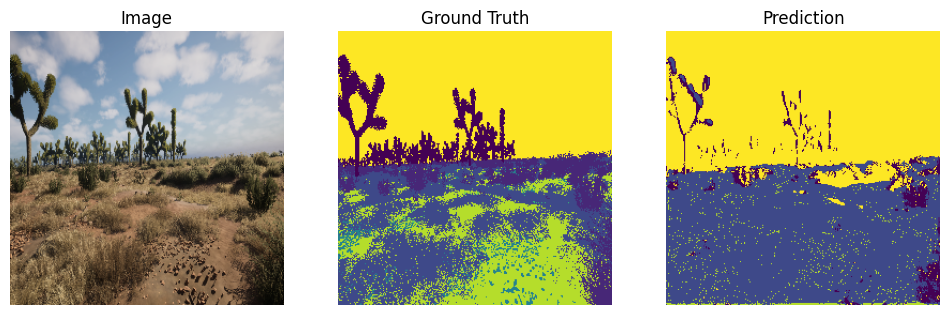

In [51]:
images, masks = next(val_gen)
preds = model.predict(images)

import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Image")
plt.imshow(images[0])
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Ground Truth")
plt.imshow(np.argmax(masks[0], axis=-1))
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Prediction")
plt.imshow(np.argmax(preds[0], axis=-1))
plt.axis("off")

plt.show()
